# Simulating lossy images from modulation spectroscopy

This notebook contains the code to 
- calculate and plot local trap frquencies for the FermiQP sheet trap
- simulate the loss from modulation spectroscopy 
- generate and save the final densities after modulation spectroscopy (for further processing to gif)

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import hbar, k as k_B
import matplotlib.colors as colors

import sys
sys.path.append('..')
from settings import *
from lattice.opticallattice import *

import fermiqp_style as fqpstyle
fqpstyle.set_theme()


## New sheet trap parameters

This is the new setup with the AOD and high powr up to 39W at atoms. THese cells are kept as a reference to benchmark the new code.

In [44]:
power=39
waisty_vertical=3.9e-6
wavelen=1.070e-6
waist_hor = 180*1e-6

U = power2freq(power=power, 
               waist = waist_hor,
               waisty=waisty_vertical)
trap = DipoleTrap(waist=waist_hor,
                  waisty=waisty_vertical,
                  wavelen=wavelen,
                  U=U)
trap.trap_freq(unit='Hz',axis='radial')[1]/1e3

140.15544510347067

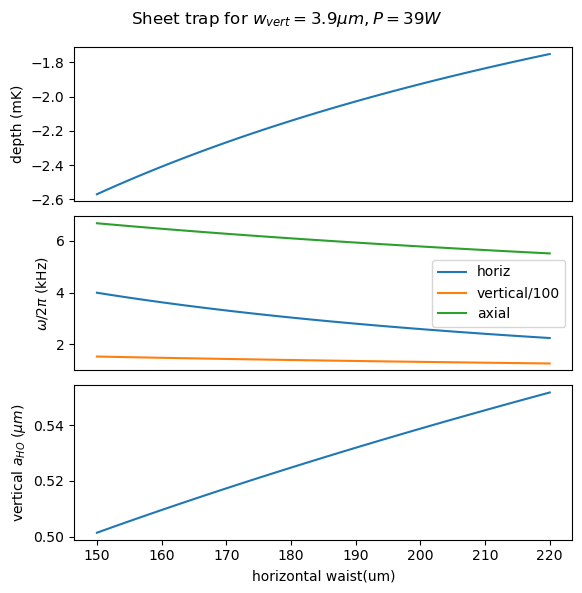

In [ ]:
power=39
waisty_vertical=3.9e-6
wavelen=1.070e-6
waist_hor = np.linspace(150,220,100)*1e-6

U = power2freq(power=power, 
               waist = waist_hor,
               waisty=waisty_vertical)
trap = DipoleTrap(waist=waist_hor,
                  waisty=waisty_vertical,
                  wavelen=wavelen,
                  U=U)

fig, axs = plt.subplots(3,1,figsize=(6,6))
axs[0].plot(waist_hor*1e6,freq2temp(U)*1e3)
axs[1].plot(waist_hor*1e6,
            trap.trap_freq(unit='Hz',axis='radial')[0]/1e3,
            label='horiz')
axs[1].plot(waist_hor*1e6,
            trap.trap_freq(unit='Hz',axis='radial')[1]/100/1e3,
            label='vertical/100')
axs[1].plot(waist_hor*1e6,
            trap.trap_freq(unit='Hz',axis='axial')/1e3,
            label='axial')
axs[0].set_ylabel('depth (mK)')
axs[2].set_xlabel('horizontal waist(um)')
axs[1].set_ylabel(r'$\omega/2\pi$ (kHz)')
axs[1].legend()

axs[0].set_xticks([])
axs[1].set_xticks([])

# for a_ho in trap.a_ho(U=U):
#     axs[2].plot(waist_hor*1e6,
#             a_ho*1e6,
#             label='axial')
axs[2].plot(waist_hor*1e6,
             trap.a_ho(U=U)[2]*1e6,
             label='axial')
axs[2].set_ylabel(r'vertical $a_{HO}$ ($\mu m$)')
plt.suptitle(r'Sheet trap for $w_{vert} = '+str(np.round(waisty_vertical*1e6,2))+ '\mu m, P='+
             str(np.round(power,2))+ 'W$')
plt.tight_layout()


## Calculate intensity in any 2D-plane for a Gaussian beam with arbitrary k-vector

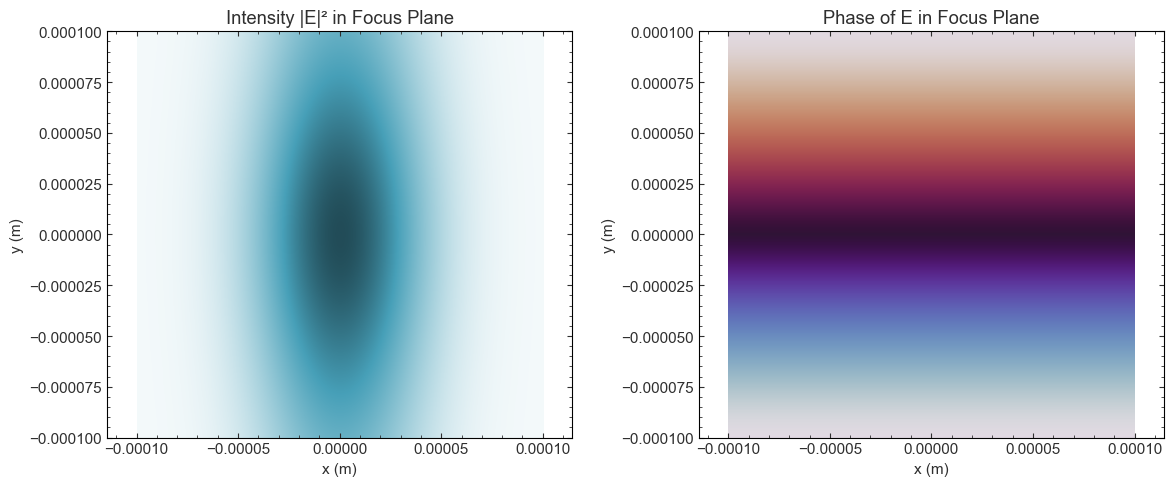

In [222]:
def normalize(v):
    return v / np.linalg.norm(v)

def build_rotation_matrix(k_vec):
    k_hat = normalize(k_vec)
    if np.allclose(k_hat, [0, 0, 1]):
        ref = np.array([1, 0, 0])
    else:
        ref = np.array([0, 0, 1])

    e_x_prime = normalize(np.cross(ref, k_hat))
    e_y_prime = np.cross(k_hat, e_x_prime)
    e_z_prime = k_hat

    R = np.vstack((e_x_prime, e_y_prime, e_z_prime)).T
    return R

def gaussian_beam_field(X, Y, Z, beam_params):
    k_vec = np.array(beam_params['k_vec'])
    w0x, w0y = beam_params['w0x'], beam_params['w0y']
    lambda0 = beam_params['lambda']
    waist_pos = np.array(beam_params['waist_pos'])
    E0 = beam_params['E0']

    k_mag = np.linalg.norm(k_vec)
    zRx = np.pi * w0x**2 / lambda0
    zRy = np.pi * w0y**2 / lambda0

    R = build_rotation_matrix(k_vec)

    # Flatten the meshgrid arrays for vectorized operations
    X_flat = X.flatten()
    Y_flat = Y.flatten()
    Z_flat = Z.flatten()

    r_lab = np.vstack((X_flat - waist_pos[0], Y_flat - waist_pos[1], Z_flat - waist_pos[2]))
    r_beam = R.T @ r_lab
    x_prime, y_prime, z_prime = r_beam[0], r_beam[1], r_beam[2]

    wx = w0x * np.sqrt(1 + (z_prime / zRx)**2)
    wy = w0y * np.sqrt(1 + (z_prime / zRy)**2)

    Rx = np.where(z_prime != 0, z_prime * (1 + (zRx / z_prime)**2), np.inf)
    Ry = np.where(z_prime != 0, z_prime * (1 + (zRy / z_prime)**2), np.inf)

    gouy = np.arctan(z_prime / zRx) + np.arctan(z_prime / zRy)

    amplitude = E0 * (w0x / wx) * (w0y / wy)
    envelope = np.exp(- (x_prime**2 / wx**2 + y_prime**2 / wy**2))
    phase = np.exp(-1j * (k_mag * z_prime + k_mag * (x_prime**2 / (2 * Rx) + y_prime**2 / (2 * Ry)) - gouy))

    E = amplitude * envelope * phase

    # Reshape back to meshgrid shape
    return E.reshape(X.shape)

# Example: Define beam and meshgrid
beam_params = {
    'k_vec': [0, 1, 0],       # Arbitrary propagation direction
    'w0x': 60e-6,              # 1 mm waist x
    'w0y': 6e-6,            # 0.5 mm waist y
    'lambda': 1070e-9,         # 633 nm wavelength
    'waist_pos': [0, 0, 0],   # Beam waist at origin
    'E0': 1.0                 # Field amplitude
}

# Define meshgrid for the focus plane z=0
x = np.linspace(-100e-6, 100e-6, 500)
y = np.linspace(-100e-6, 100e-6, 500)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

# Compute the electric field
E = gaussian_beam_field(X, Y, Z, beam_params)

# Plot intensity and phase
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Intensity plot
axs[0].imshow(np.abs(E)**2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='density')
axs[0].set_title('Intensity |E|² in Focus Plane')
axs[0].set_xlabel('x (m)')
axs[0].set_ylabel('y (m)')
axs[0].axis('equal')

# Phase plot
axs[1].imshow(np.angle(E), extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='twilight')
axs[1].set_title('Phase of E in Focus Plane')
axs[1].set_xlabel('x (m)')
axs[1].set_ylabel('y (m)')
axs[1].axis('equal')
plt.tight_layout()
plt.show()

In [223]:
def calculate_trap_frequency(U, w_trap):
    """
    U: trap depth (Hz)
    w_trap: Beam waist in the trapping direction (m)
    mass: Particle mass (kg)
    alpha: Polarizability (J m^2 / W)
    """
    mass = 6 * 1.67e-27
    f_trap = np.sqrt(4 * np.abs(U) * hplanck/ (mass * w_trap**2)) / (2 * np.pi)  # Trap frequency in Hz
    return f_trap

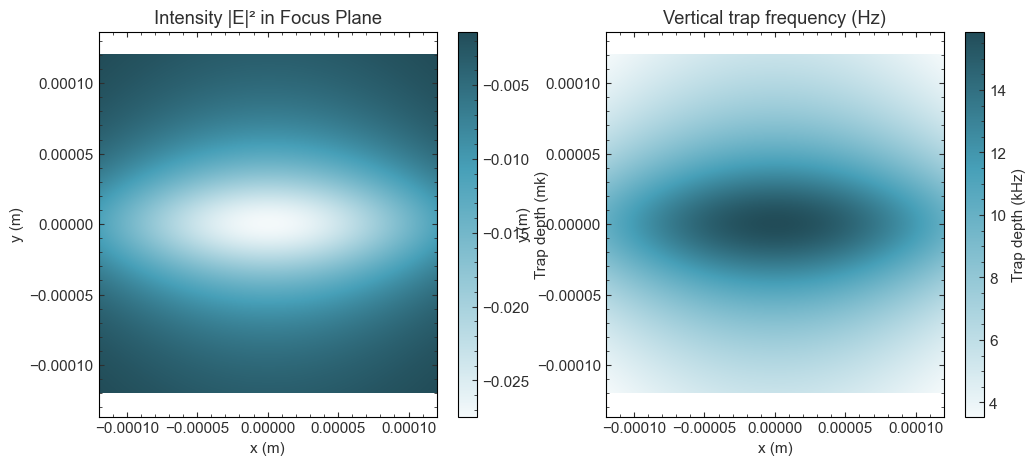

In [224]:
power=0.5
waisty_vertical=3.9e-6
wavelen=1.070e-6
waist_hor = 180*1e-6

U = power2freq(power=power, 
               waist = waist_hor,
               waisty=waisty_vertical)
trap = DipoleTrap(waist=waist_hor,
                  waisty=waisty_vertical,
                  wavelen=wavelen,
                  U=U)
# Example: Define beam and meshgrid
beam_params = {
    'k_vec': [0, 1, 0],       # Arbitrary propagation direction
    'w0x': waist_hor,              # 1 mm waist x
    'w0y': waisty_vertical,            # 0.5 mm waist y
    'lambda': 1070e-9,         # 633 nm wavelength
    'waist_pos': [0, 0, 0],   # Beam waist at origin
    'E0': 1.0                 # Field amplitude
}

# Define meshgrid for the focus plane z=0
grid_size = 120e-6
x = np.linspace(-grid_size,grid_size,500)
y = np.linspace(-grid_size,grid_size,500)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

# Compute the electric field
E = gaussian_beam_field(X, Y, Z, beam_params)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Intensity plot
im0= axs[0].imshow(freq2temp(U)*1e3*np.abs(E)**2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='density')
axs[0].set_title('Intensity |E|² in Focus Plane')
axs[0].set_xlabel('x (m)')
axs[0].set_ylabel('y (m)')
axs[0].axis('equal')
plt.colorbar(im0, ax=axs[0], label='Trap depth (mk)')

# trap frequency ploy
im1= axs[1].imshow(calculate_trap_frequency(U*np.abs(E)**2,waisty_vertical)/1e3, 
                    extent=[x.min(), x.max(), y.min(), y.max()], 
                    origin='lower', cmap='density'
                    )
axs[1].set_title('Vertical trap frequency (Hz)')
axs[1].set_xlabel('x (m)')
axs[1].set_ylabel('y (m)')
axs[1].axis('equal')
plt.colorbar(im1, ax=axs[1], label='Trap depth (kHz)')

In [225]:
# find maximum of trap frequency to benchmark with the results from previous calculations
np.max(calculate_trap_frequency(temp2freq(2.2e-3)*np.abs(E)**2,3.9e-6)/1e3)

142.06773979138126

## Simulating the loss spectroscopy


Simulating Li-6 parametric heating at 1000 Hz...
  (Resonance occurs where local f_trap = 500 Hz)


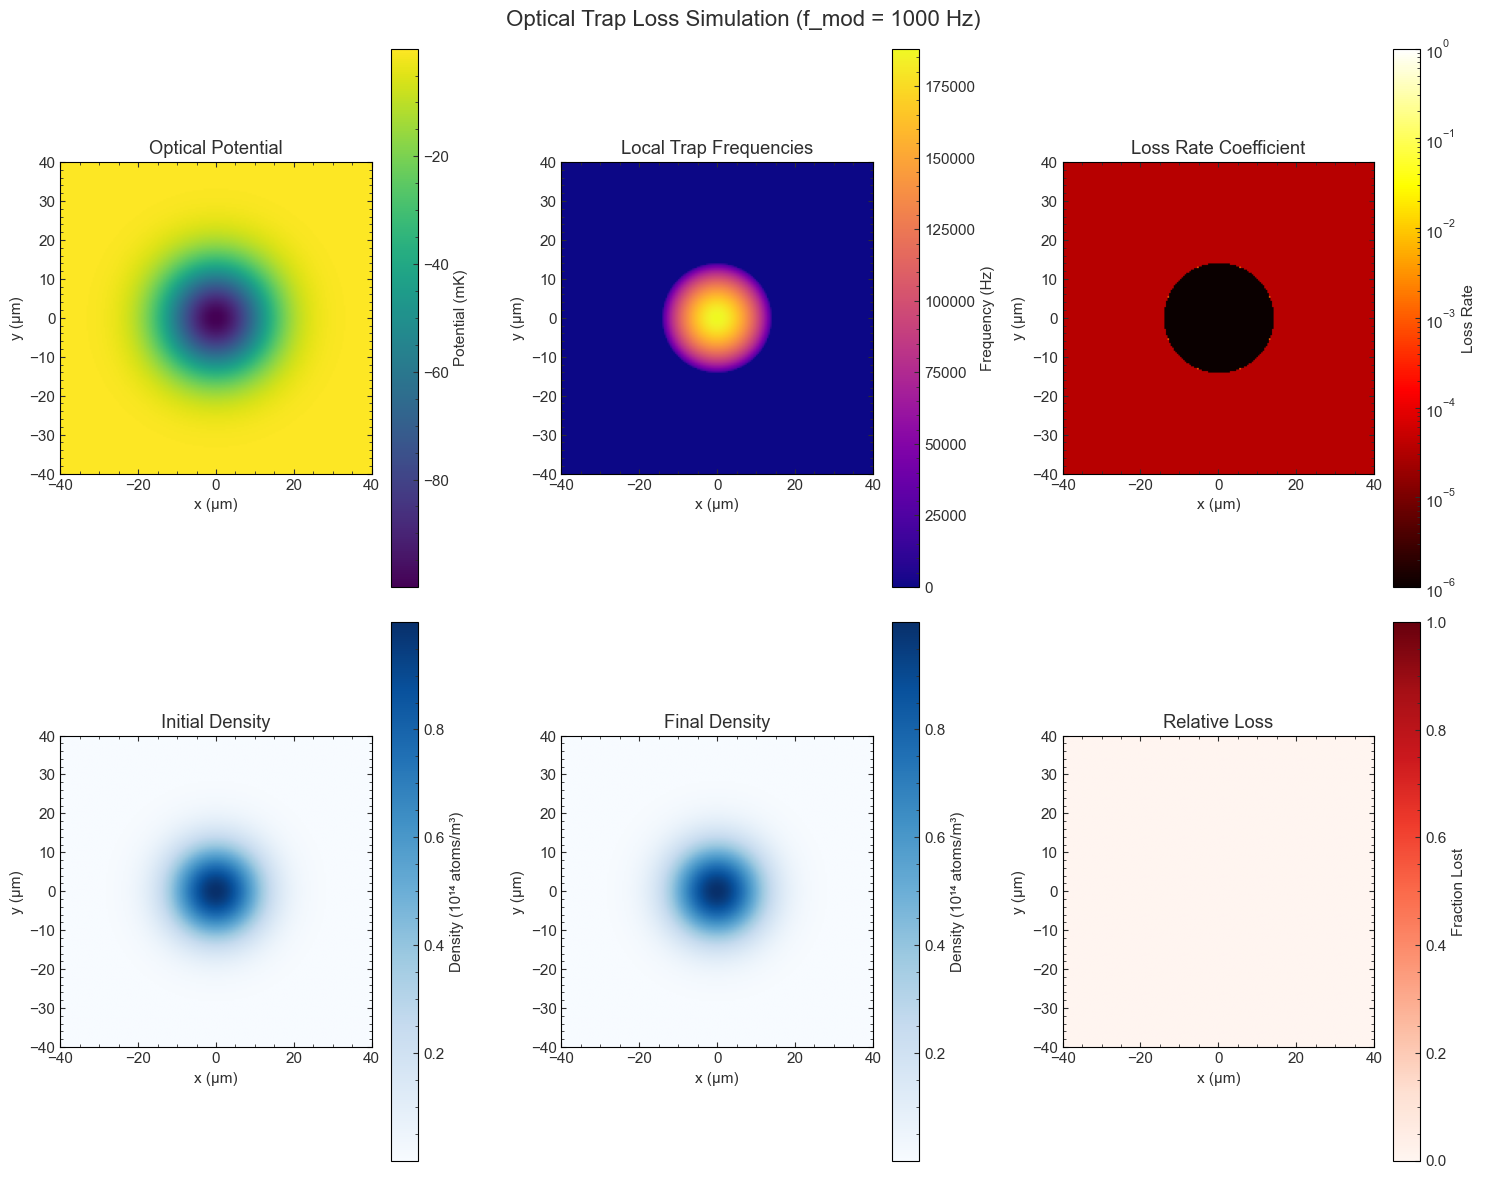

Maximum loss: 0.002
Average loss: 0.000

Simulating Li-6 parametric heating at 2000 Hz...
  (Resonance occurs where local f_trap = 1000 Hz)


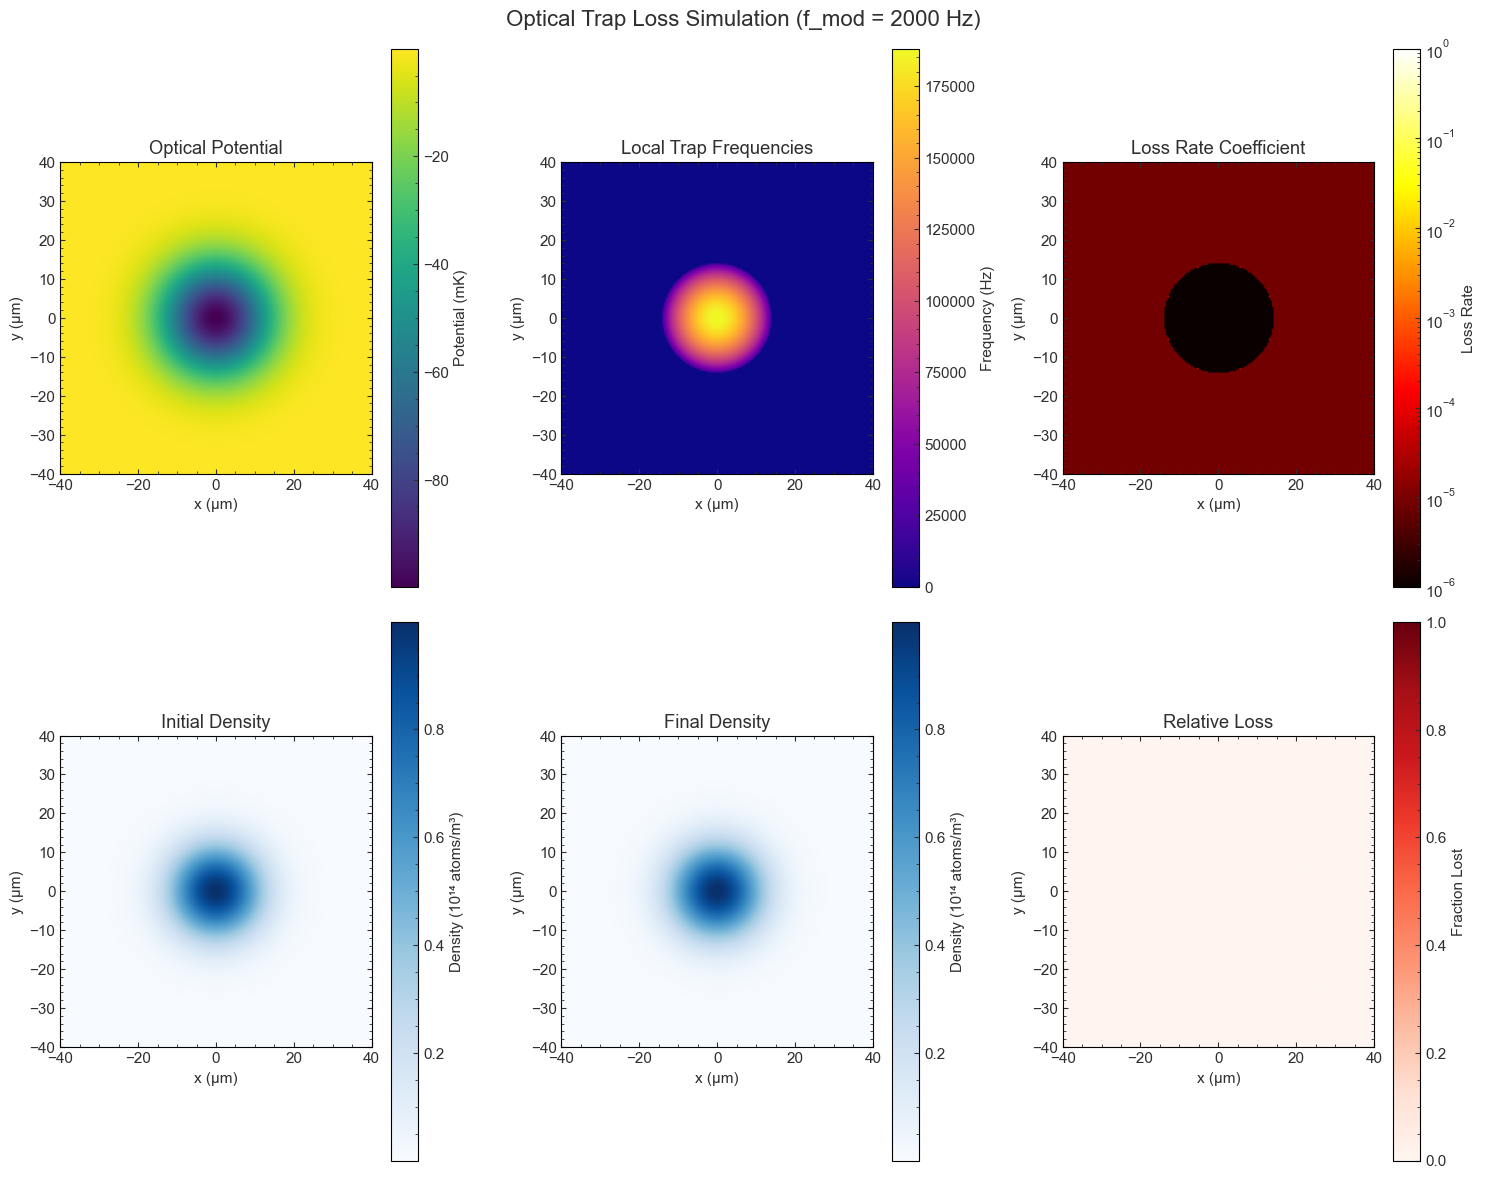

Maximum loss: 0.000
Average loss: 0.000

Simulating Li-6 parametric heating at 4000 Hz...
  (Resonance occurs where local f_trap = 2000 Hz)


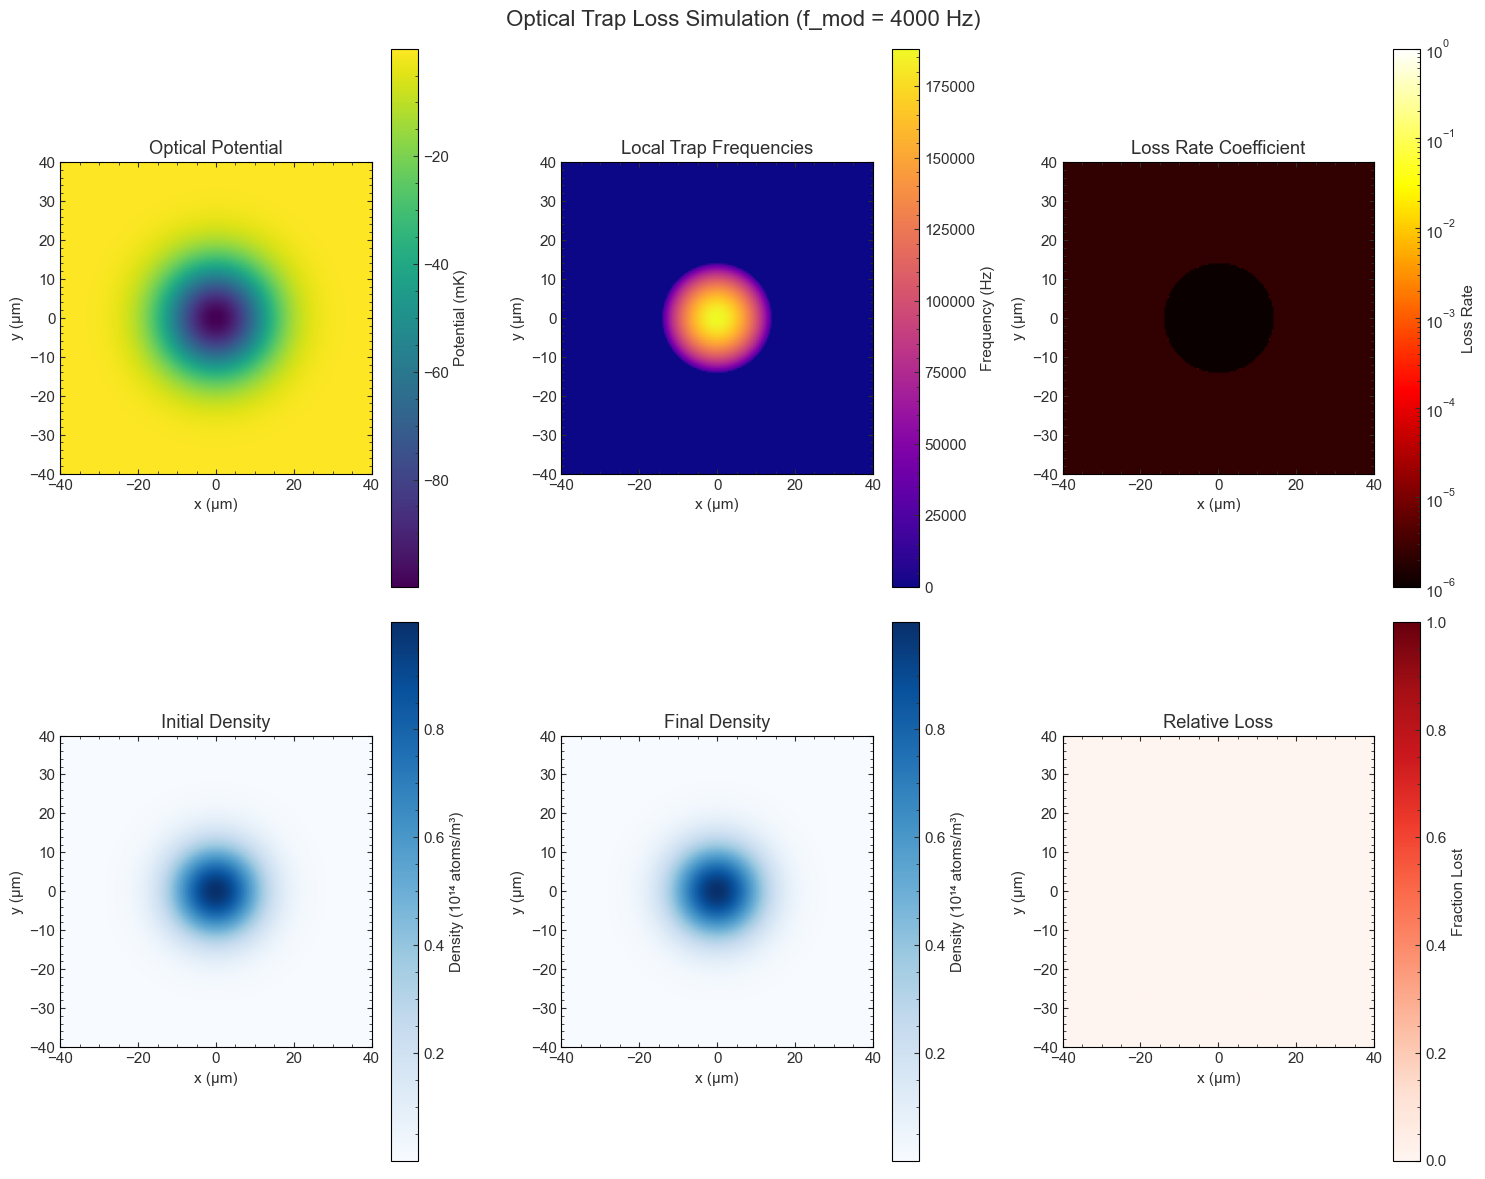

Maximum loss: 0.000
Average loss: 0.000

Running elliptical trap example...


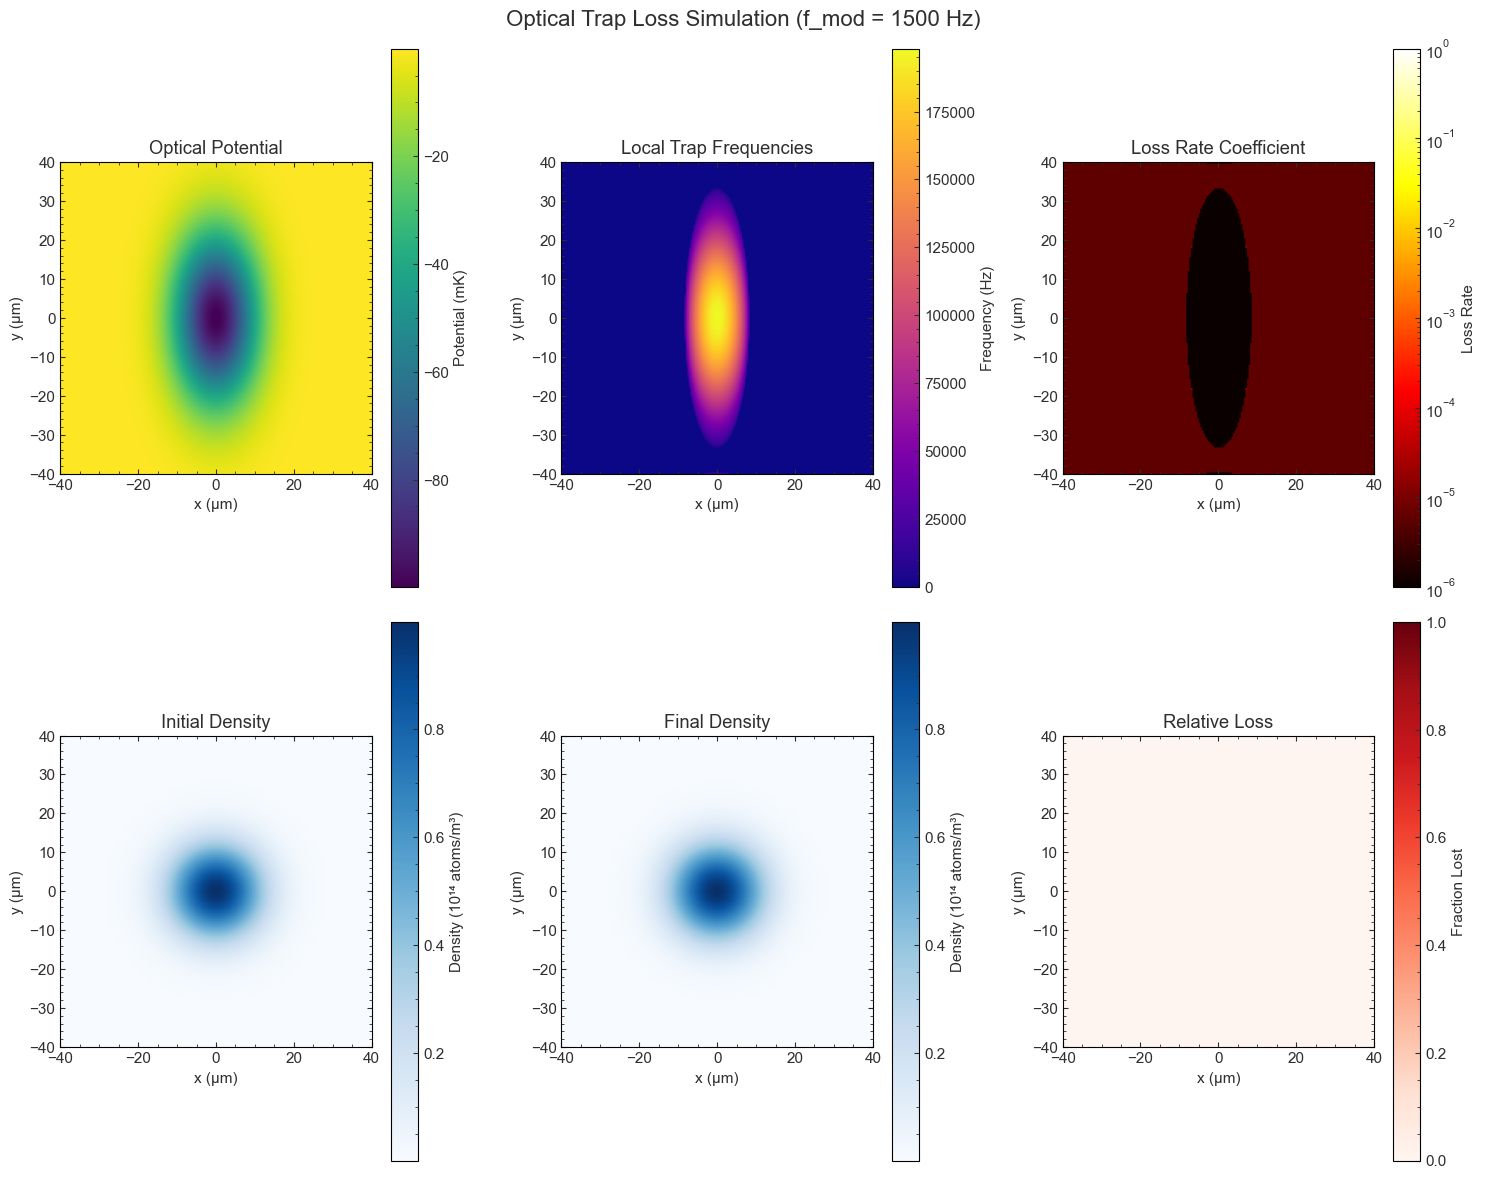

Elliptical trap simulation completed!

Running custom frequency array example...
Using direct frequency array input...


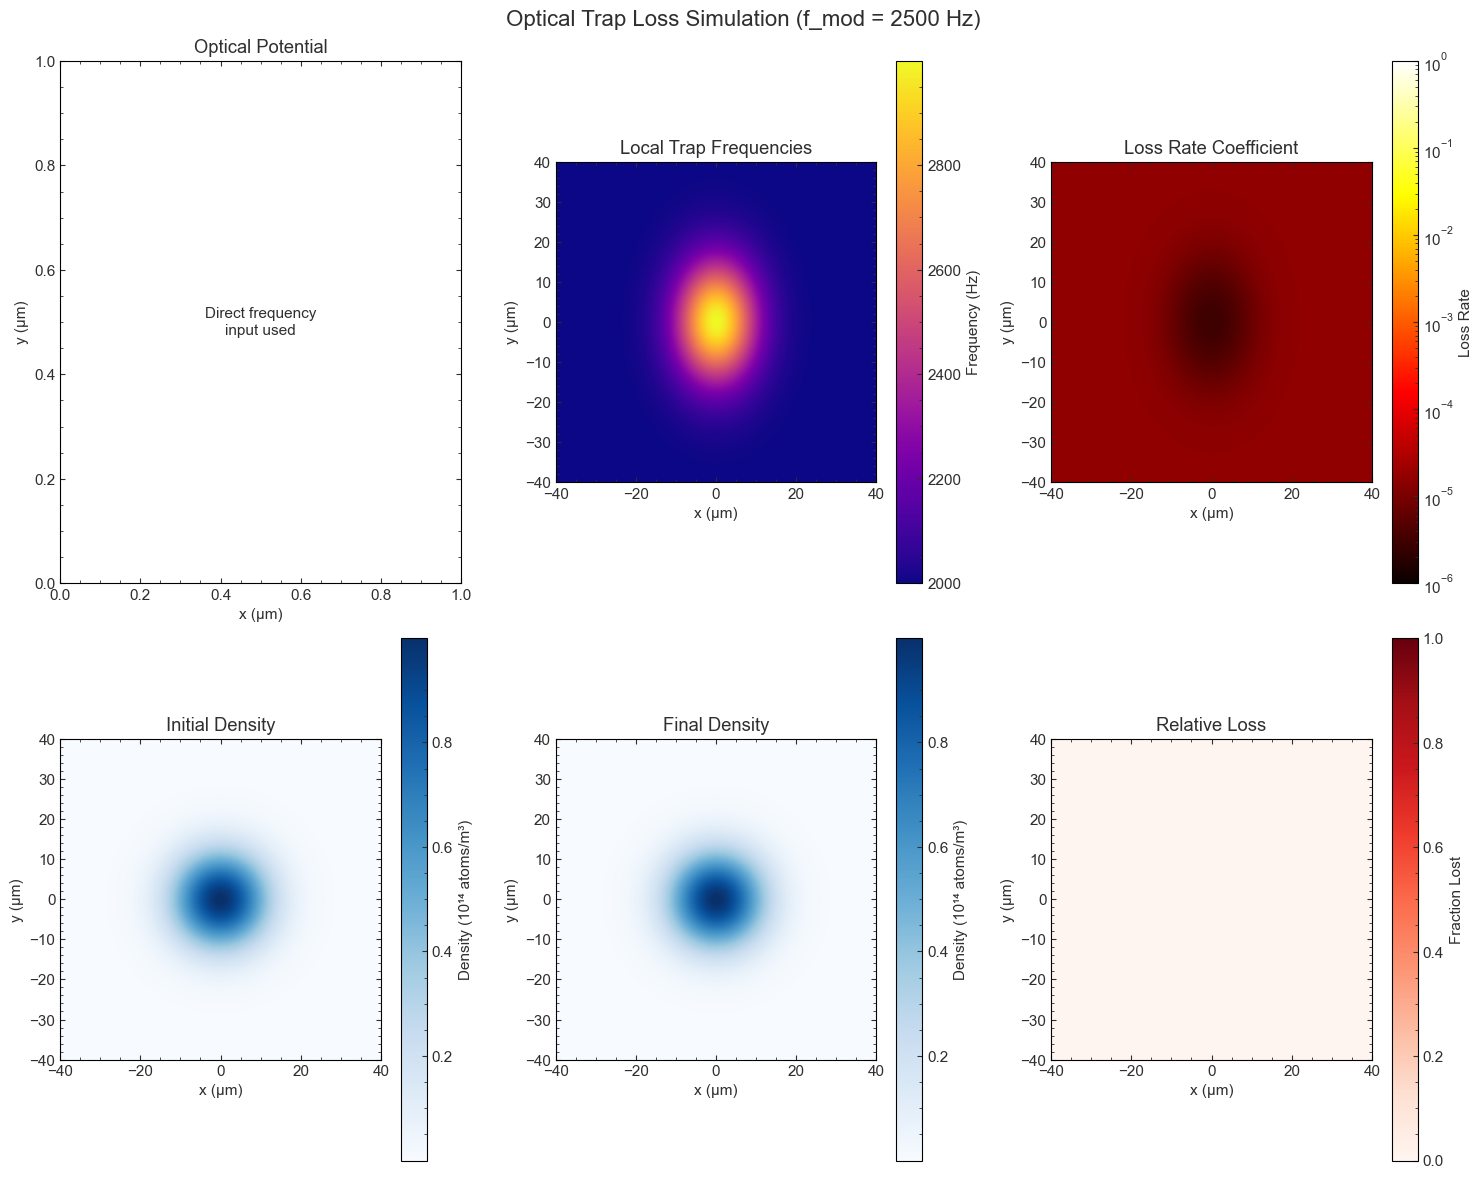

Custom frequency array simulation completed!
Frequency range: 2000 - 2999 Hz

Running modulation frequency scan example...
Running modulation frequency scan...
  Simulating f_mod = 1600 Hz...
  Simulating f_mod = 2400 Hz...
  Simulating f_mod = 3200 Hz...
  Simulating f_mod = 4000 Hz...
  Simulating f_mod = 4800 Hz...
  Simulating f_mod = 5600 Hz...


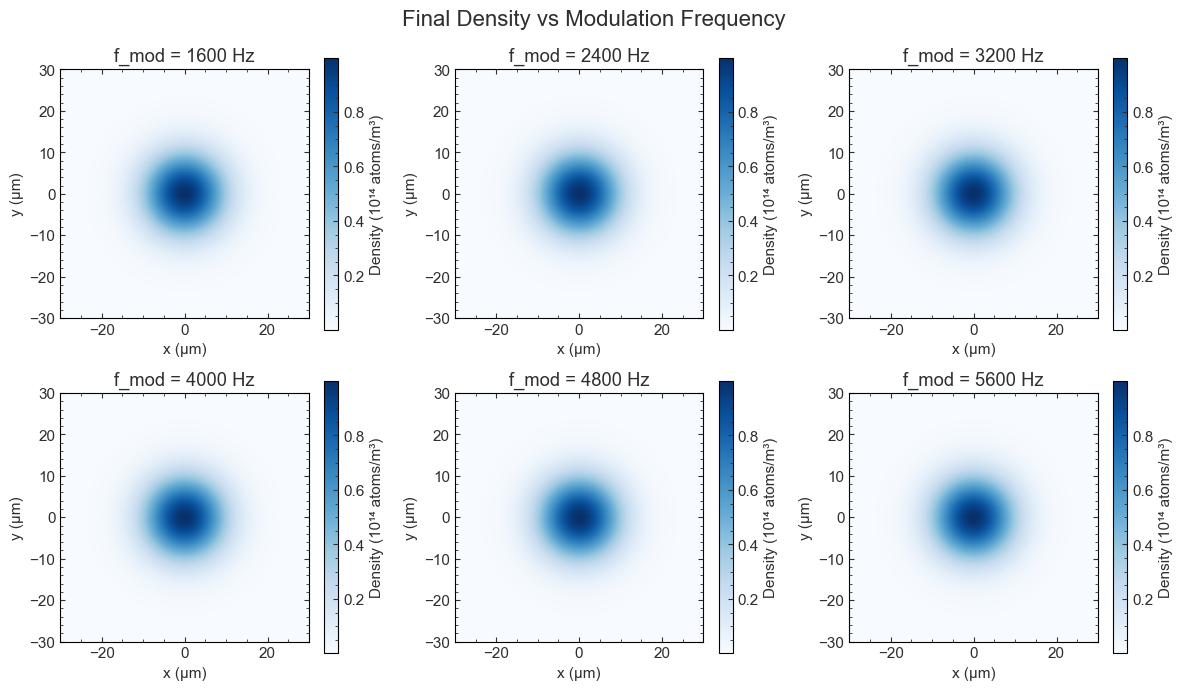

Modulation frequency scan completed!

Running elliptical cloud example...
Testing elliptical initial cloud distributions...
  Running Circular Cloud...


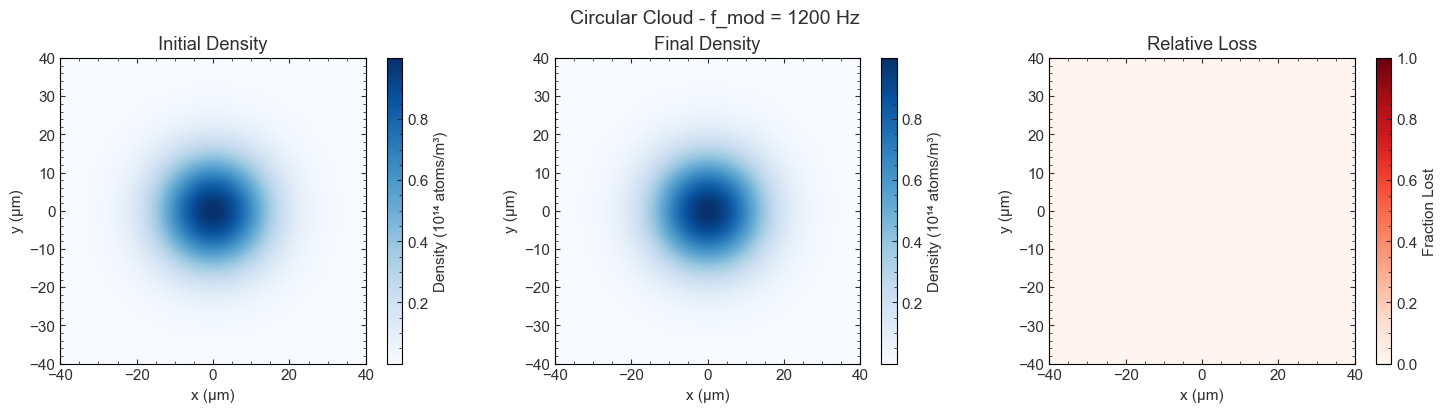

    Aspect ratio 1.00: Max loss = 0.014, Mean loss = 0.000
  Running Elliptical Cloud (1:2)...


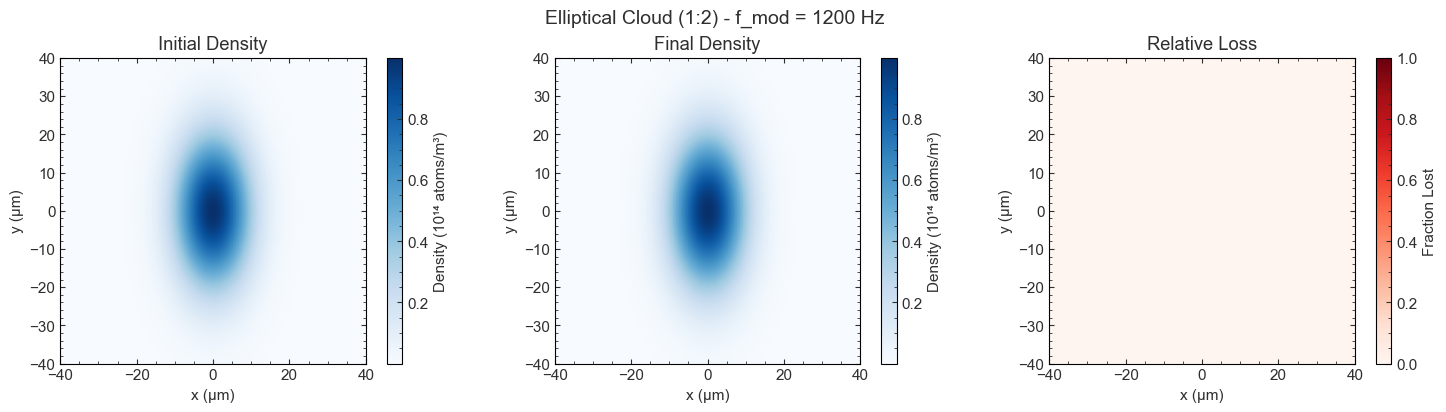

    Aspect ratio 0.50: Max loss = 0.014, Mean loss = 0.000
  Running Elliptical Cloud (2:1)...


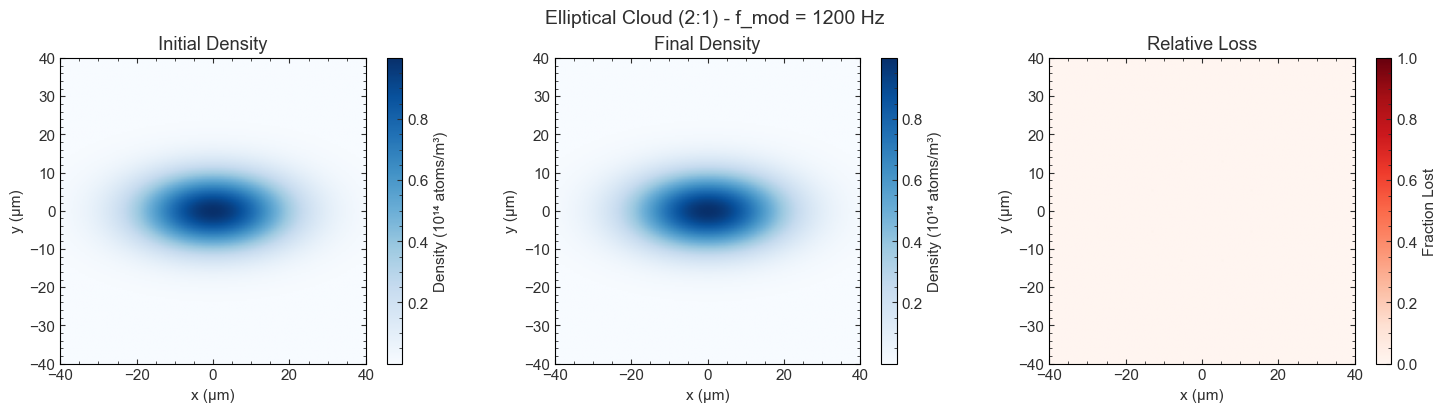

    Aspect ratio 2.00: Max loss = 0.014, Mean loss = 0.000
Elliptical cloud examples completed!

Running save/load scan example...
Running and saving modulation frequency scan...
Running modulation frequency scan for 9 frequencies...
  Processing f_mod = 1600 Hz (1/9)
  Processing f_mod = 2000 Hz (2/9)
  Processing f_mod = 2400 Hz (3/9)
  Processing f_mod = 2800 Hz (4/9)
  Processing f_mod = 3200 Hz (5/9)
  Processing f_mod = 3600 Hz (6/9)
  Processing f_mod = 4000 Hz (7/9)
  Processing f_mod = 4400 Hz (8/9)
  Processing f_mod = 4800 Hz (9/9)
Data saved to li6_trap_scan.npz
Scan completed!

Scan saved! Data shape: (9, 128, 128)
Frequencies: [1600. 2000. 2400. 2800. 3200. 3600. 4000. 4400. 4800.]

Loading data back...
Loaded data shape: (9, 128, 128)
Frequency range: 1600 - 4800 Hz


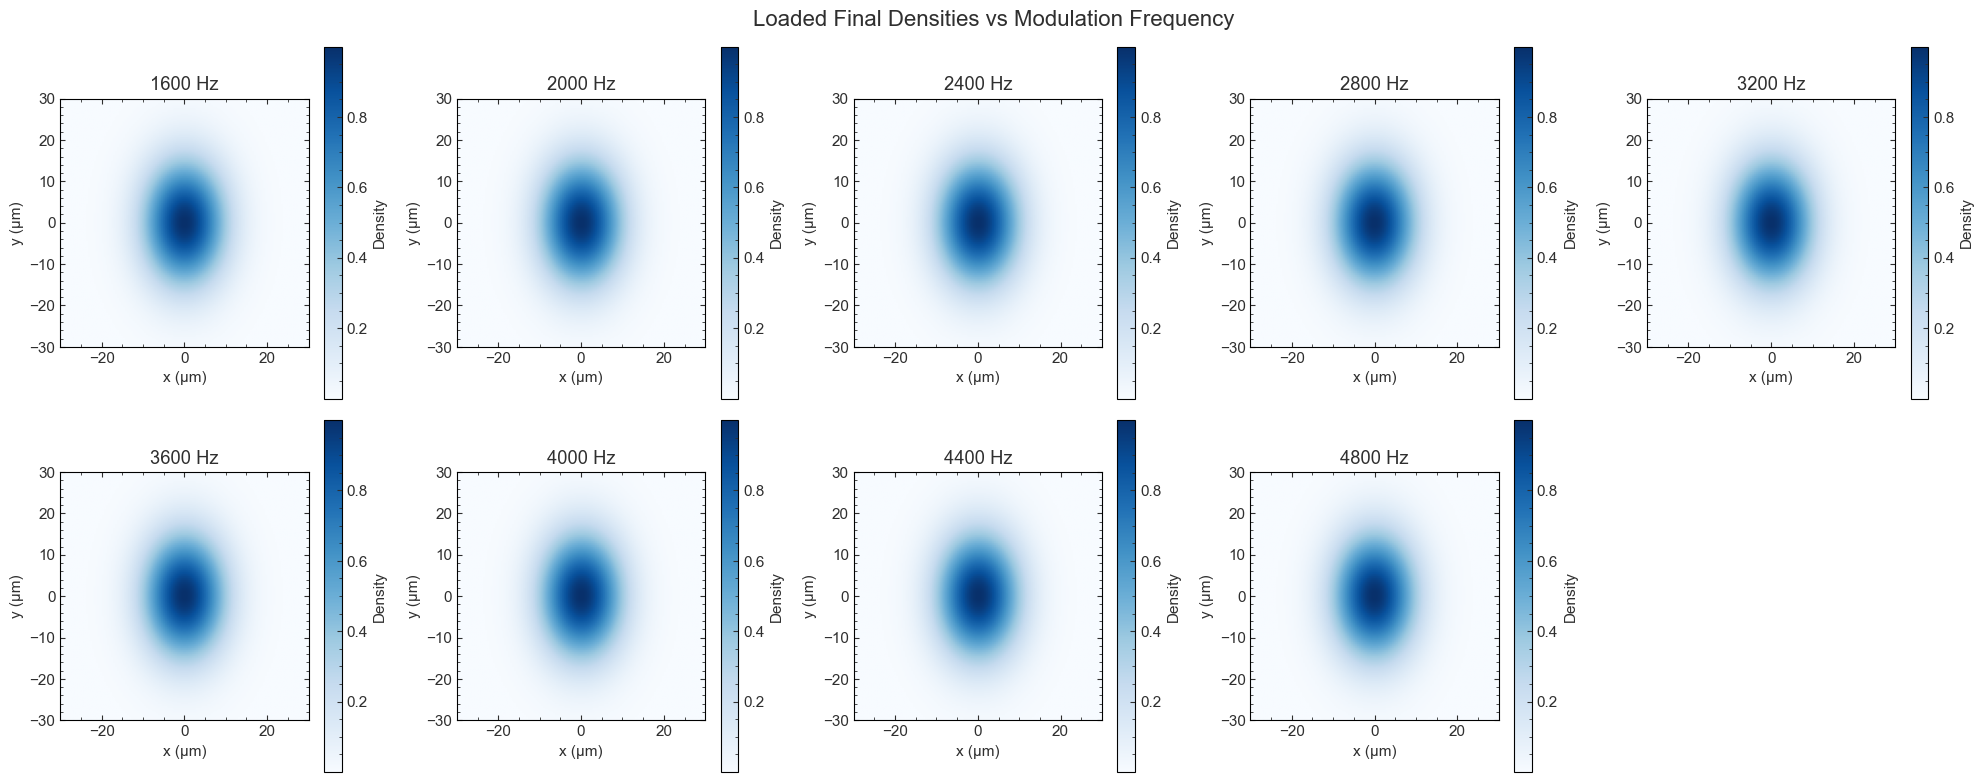

Save/load example completed!


In [197]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import hbar, k as k_B
import matplotlib.colors as colors

class OpticalTrapSimulator:
    def __init__(self, grid_size=256, physical_size=100e-6):
        """
        Initialize the optical trap simulator.
        
        Parameters:
        -----------
        grid_size : int
            Number of grid points per dimension
        physical_size : float
            Physical size of the simulation grid in meters
        """
        self.grid_size = grid_size
        self.physical_size = physical_size
        self.dx = physical_size / grid_size
        
        # Create coordinate grids
        x = np.linspace(-physical_size/2, physical_size/2, grid_size)
        y = np.linspace(-physical_size/2, physical_size/2, grid_size)
        self.X, self.Y = np.meshgrid(x, y)
        self.R = np.sqrt(self.X**2 + self.Y**2)
        
    def gaussian_potential(self, depth=100, waist_x=20e-6, waist_y=None):
        """
        Create a Gaussian optical potential (circular or elliptical).
        
        Parameters:
        -----------
        depth : float
            Potential depth in mK (positive for attractive potential)
        waist_x : float
            Gaussian beam waist in x-direction in meters
        waist_y : float or None
            Gaussian beam waist in y-direction in meters. If None, uses waist_x (circular)
            
        Returns:
        --------
        numpy.ndarray : 2D potential array in Joules
        """
        if waist_y is None:
            waist_y = waist_x
            
        # Convert mK to Joules
        depth_joules = depth * 1e-3 * k_B
        
        # Elliptical Gaussian potential
        return -depth_joules * np.exp(-2 * (self.X**2 / waist_x**2 + self.Y**2 / waist_y**2))
    
    def custom_potential(self, potential_array):
        """
        Use a custom potential from a 2D numpy array.
        
        Parameters:
        -----------
        potential_array : numpy.ndarray
            2D array representing the potential
            
        Returns:
        --------
        numpy.ndarray : Resized potential array matching grid size
        """
        if potential_array.shape != (self.grid_size, self.grid_size):
            # Resize if necessary
            from scipy.ndimage import zoom
            zoom_factor = self.grid_size / potential_array.shape[0]
            return zoom(potential_array, zoom_factor)
        return potential_array
    
    def calculate_local_frequencies(self, potential, mass=6*1.66e-27):
        """
        Calculate local trap frequencies from potential curvature.
        
        Parameters:
        -----------
        potential : numpy.ndarray
            2D potential array
        mass : float
            Atomic mass in kg (default: Li-6)
            
        Returns:
        --------
        numpy.ndarray : 2D array of local trap frequencies in Hz
        """
        # Calculate second derivatives (curvature)
        d2V_dx2 = np.gradient(np.gradient(potential, self.dx, axis=1), self.dx, axis=1)
        d2V_dy2 = np.gradient(np.gradient(potential, self.dx, axis=0), self.dx, axis=0)
        
        # Average curvature for radial frequency
        curvature = (d2V_dx2 + d2V_dy2) / 2
        
        # Local trap frequency: ω = sqrt(curvature / mass)
        # Handle negative curvature regions
        frequencies = np.zeros_like(curvature)
        positive_mask = curvature > 0
        frequencies[positive_mask] = np.sqrt(curvature[positive_mask] / mass) / (2 * np.pi)
        
        return frequencies
    
    def initial_density(self, cloud_size_x=15e-6, cloud_size_y=None, peak_density=1e14):
        """
        Create initial atomic density distribution (circular or elliptical).
        
        Parameters:
        -----------
        cloud_size_x : float
            1/e radius of the atomic cloud in x-direction in meters
        cloud_size_y : float or None
            1/e radius of the atomic cloud in y-direction in meters. If None, uses cloud_size_x (circular)
        peak_density : float
            Peak density in atoms/m³
            
        Returns:
        --------
        numpy.ndarray : 2D initial density distribution
        """
        if cloud_size_y is None:
            cloud_size_y = cloud_size_x
            
        # Elliptical Gaussian density distribution
        return peak_density * np.exp(-(self.X**2 / cloud_size_x**2 + self.Y**2 / cloud_size_y**2))
    
    def loss_rate(self, local_freq, mod_freq, mod_depth=0.1, linewidth=100):
        """
        Calculate loss rate based on parametric heating resonance condition.
        
        For intensity modulation, parametric heating is strongest when the modulation
        frequency equals twice the local trap frequency: f_mod = 2 * f_trap
        
        Parameters:
        -----------
        local_freq : numpy.ndarray
            Local trap frequencies in Hz
        mod_freq : float
            Modulation frequency in Hz
        mod_depth : float
            Modulation depth (fractional)
        linewidth : float
            Loss linewidth in Hz
            
        Returns:
        --------
        numpy.ndarray : Loss rate coefficient (dimensionless)
        """
        # Detuning from parametric heating resonance: δ = f_mod - 2*f_trap
        # Resonance occurs when δ = 0, i.e., f_mod = 2*f_trap
        delta = mod_freq - 2 * local_freq
        
        # Lorentzian lineshape with modulation depth scaling
        gamma = linewidth / 2
        loss_coefficient = mod_depth**2 * gamma**2 / (delta**2 + gamma**2)
        
        return loss_coefficient
    
    def simulate_loss(self, potential=None, mod_freq=None, cloud_size=15e-6, 
                     mod_depth=0.1, linewidth=100, loss_time=1.0,
                     mass=6*1.66e-27, peak_density=1e14, trap_frequencies=None,
                     cloud_size_x=None, cloud_size_y=None):
        """
        Main simulation function.
        
        Parameters:
        -----------
        potential : numpy.ndarray, str, or None
            Either 2D potential array, 'gaussian' for default Gaussian, or None if using trap_frequencies
        mod_freq : float
            Modulation frequency in Hz
        cloud_size : float
            1/e radius of atomic cloud in meters (used if cloud_size_x/y not specified)
        mod_depth : float
            Modulation depth (fractional)
        linewidth : float
            Loss linewidth in Hz
        loss_time : float
            Time duration for loss calculation in seconds
        mass : float
            Atomic mass in kg (default: Li-6)
        peak_density : float
            Initial peak density in atoms/m³
        trap_frequencies : numpy.ndarray or None
            2D array of local trap frequencies in Hz. If provided, overrides potential calculation
        cloud_size_x : float or None
            1/e radius of atomic cloud in x-direction. If None, uses cloud_size
        cloud_size_y : float or None
            1/e radius of atomic cloud in y-direction. If None, uses cloud_size_x (or cloud_size)
            
        Returns:
        --------
        dict : Dictionary containing simulation results
        """
        # Handle cloud size parameters for backward compatibility
        if cloud_size_x is None:
            cloud_size_x = cloud_size
        if cloud_size_y is None:
            cloud_size_y = cloud_size_x
        # Handle trap frequencies input
        if trap_frequencies is not None:
            # Use provided frequency array
            if trap_frequencies.shape != (self.grid_size, self.grid_size):
                raise ValueError(f"trap_frequencies must have shape ({self.grid_size}, {self.grid_size})")
            local_freqs = trap_frequencies
            V = None  # No potential calculation needed
        else:
            # Calculate from potential
            if potential is None:
                raise ValueError("Either 'potential' or 'trap_frequencies' must be provided")
            
            # Handle potential input
            if isinstance(potential, str) and potential.lower() == 'gaussian':
                V = self.gaussian_potential()
            elif isinstance(potential, np.ndarray):
                V = self.custom_potential(potential)
            else:
                raise ValueError("Potential must be 'gaussian' or numpy array")
            
            # Calculate local frequencies
            local_freqs = self.calculate_local_frequencies(V, mass)
        
        # Initial density
        initial_n = self.initial_density(cloud_size_x, cloud_size_y, peak_density)
        
        # Calculate loss rates
        loss_rates = self.loss_rate(local_freqs, mod_freq, mod_depth, linewidth)
        
        # Apply exponential loss over time
        final_density = initial_n * np.exp(-loss_rates * loss_time)
        
        # Calculate relative loss
        relative_loss = 1 - (final_density / initial_n)
        
        return {
            'potential': V,
            'local_frequencies': local_freqs,
            'initial_density': initial_n,
            'final_density': final_density,
            'relative_loss': relative_loss,
            'loss_rates': loss_rates,
            'coordinates': (self.X, self.Y),
            'used_frequency_array': trap_frequencies is not None
        }
    
    def plot_results(self, results, mod_freq, figsize=(15, 12)):
        """
        Plot comprehensive simulation results.
        
        Parameters:
        -----------
        results : dict
            Results dictionary from simulate_loss
        mod_freq : float
            Modulation frequency in Hz
        figsize : tuple
            Figure size
        """
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        fig.suptitle(f'Optical Trap Loss Simulation (f_mod = {mod_freq:.0f} Hz)', fontsize=16)
        
        # Convert to micrometers for plotting
        x_um = self.X * 1e6
        y_um = self.Y * 1e6
        extent = [-self.physical_size/2*1e6, self.physical_size/2*1e6, 
                 -self.physical_size/2*1e6, self.physical_size/2*1e6]
        
        # Potential (skip if using direct frequency input)
        if results['potential'] is not None:
            im1 = axes[0,0].imshow(results['potential']/(k_B*1e-3), extent=extent, 
                                  cmap='viridis', origin='lower')
            axes[0,0].set_title('Optical Potential')
            axes[0,0].set_xlabel('x (μm)')
            axes[0,0].set_ylabel('y (μm)')
            plt.colorbar(im1, ax=axes[0,0], label='Potential (mK)')
        else:
            axes[0,0].text(0.5, 0.5, 'Direct frequency\ninput used', 
                          transform=axes[0,0].transAxes, ha='center', va='center')
            axes[0,0].set_title('Optical Potential')
            axes[0,0].set_xlabel('x (μm)')
            axes[0,0].set_ylabel('y (μm)')
        
        # Local frequencies
        im2 = axes[0,1].imshow(results['local_frequencies'], extent=extent, 
                              cmap='plasma', origin='lower')
        axes[0,1].set_title('Local Trap Frequencies')
        axes[0,1].set_xlabel('x (μm)')
        axes[0,1].set_ylabel('y (μm)')
        plt.colorbar(im2, ax=axes[0,1], label='Frequency (Hz)')
        
        # Loss rates
        im3 = axes[0,2].imshow(results['loss_rates'], extent=extent, 
                              cmap='hot', origin='lower', norm=colors.LogNorm(vmin=1e-6, vmax=1))
        axes[0,2].set_title('Loss Rate Coefficient')
        axes[0,2].set_xlabel('x (μm)')
        axes[0,2].set_ylabel('y (μm)')
        plt.colorbar(im3, ax=axes[0,2], label='Loss Rate')
        
        # Initial density
        im4 = axes[1,0].imshow(results['initial_density']*1e-14, extent=extent, 
                              cmap='Blues', origin='lower')
        axes[1,0].set_title('Initial Density')
        axes[1,0].set_xlabel('x (μm)')
        axes[1,0].set_ylabel('y (μm)')
        plt.colorbar(im4, ax=axes[1,0], label='Density (10¹⁴ atoms/m³)')
        
        # Final density
        im5 = axes[1,1].imshow(results['final_density']*1e-14, extent=extent, 
                              cmap='Blues', origin='lower')
        axes[1,1].set_title('Final Density')
        axes[1,1].set_xlabel('x (μm)')
        axes[1,1].set_ylabel('y (μm)')
        plt.colorbar(im5, ax=axes[1,1], label='Density (10¹⁴ atoms/m³)')
        
        # Relative loss
        im6 = axes[1,2].imshow(results['relative_loss'], extent=extent, 
                              cmap='Reds', origin='lower', vmin=0, vmax=1)
        axes[1,2].set_title('Relative Loss')
        axes[1,2].set_xlabel('x (μm)')
        axes[1,2].set_ylabel('y (μm)')
        plt.colorbar(im6, ax=axes[1,2], label='Fraction Lost')
        
        plt.tight_layout()
        plt.show()
    
    def save_mod_freq_scan(self, mod_freq_list, filename_prefix='mod_freq_scan', 
                          save_format='npz', **simulation_kwargs):
        """
        Run modulation frequency scan and save results to files.
        
        Parameters:
        -----------
        mod_freq_list : list or array
            List of modulation frequencies to scan in Hz
        filename_prefix : str
            Prefix for saved files
        save_format : str
            Save format: 'npz' (compressed), 'npy' (separate files), or 'h5' (HDF5)
        **simulation_kwargs : dict
            Additional keyword arguments passed to simulate_loss()
            
        Returns:
        --------
        dict : Dictionary containing arrays and metadata
        """
        print(f"Running modulation frequency scan for {len(mod_freq_list)} frequencies...")
        
        # Initialize storage arrays
        final_densities = []
        relative_losses = []
        mod_frequencies = np.array(mod_freq_list)
        
        # Store metadata
        metadata = {
            'grid_size': self.grid_size,
            'physical_size': self.physical_size,
            'dx': self.dx,
            'simulation_params': simulation_kwargs.copy()
        }
        
        # Run simulations
        for i, mod_freq in enumerate(mod_freq_list):
            print(f"  Processing f_mod = {mod_freq:.0f} Hz ({i+1}/{len(mod_freq_list)})")
            
            # Run simulation
            results = self.simulate_loss(mod_freq=mod_freq, **simulation_kwargs)
            
            # Store results
            final_densities.append(results['final_density'])
            relative_losses.append(results['relative_loss'])
        
        # Convert to numpy arrays
        final_densities = np.array(final_densities)  # Shape: (n_freq, grid_size, grid_size)
        relative_losses = np.array(relative_losses)   # Shape: (n_freq, grid_size, grid_size)
        
        # Create coordinate arrays
        x = np.linspace(-self.physical_size/2, self.physical_size/2, self.grid_size)
        y = np.linspace(-self.physical_size/2, self.physical_size/2, self.grid_size)
        
        # Prepare data dictionary
        data_dict = {
            'final_densities': final_densities,
            'relative_losses': relative_losses,
            'mod_frequencies': mod_frequencies,
            'x_coords': x,
            'y_coords': y,
            'metadata': metadata
        }
        
        # Save data based on format
        if save_format.lower() == 'npz':
            filename = f"{filename_prefix}.npz"
            np.savez_compressed(filename, **data_dict)
            print(f"Data saved to {filename}")
            
        elif save_format.lower() == 'npy':
            # Save as separate .npy files
            np.save(f"{filename_prefix}_final_densities.npy", final_densities)
            np.save(f"{filename_prefix}_relative_losses.npy", relative_losses)
            np.save(f"{filename_prefix}_mod_frequencies.npy", mod_frequencies)
            np.save(f"{filename_prefix}_x_coords.npy", x)
            np.save(f"{filename_prefix}_y_coords.npy", y)
            
            # Save metadata as text file
            with open(f"{filename_prefix}_metadata.txt", 'w') as f:
                f.write("Modulation Frequency Scan Metadata\n")
                f.write("==================================\n\n")
                f.write(f"Grid size: {self.grid_size}\n")
                f.write(f"Physical size: {self.physical_size*1e6:.1f} μm\n")
                f.write(f"Spatial resolution: {self.dx*1e6:.2f} μm\n")
                f.write(f"Number of frequencies: {len(mod_freq_list)}\n")
                f.write(f"Frequency range: {np.min(mod_frequencies):.0f} - {np.max(mod_frequencies):.0f} Hz\n\n")
                f.write("Simulation parameters:\n")
                for key, value in simulation_kwargs.items():
                    f.write(f"  {key}: {value}\n")
            
            print(f"Data saved as separate .npy files with prefix '{filename_prefix}'")
            
        elif save_format.lower() == 'h5':
            try:
                import h5py
                filename = f"{filename_prefix}.h5"
                with h5py.File(filename, 'w') as f:
                    # Create groups
                    data_group = f.create_group('data')
                    coords_group = f.create_group('coordinates')
                    meta_group = f.create_group('metadata')
                    
                    # Save main data
                    data_group.create_dataset('final_densities', data=final_densities, compression='gzip')
                    data_group.create_dataset('relative_losses', data=relative_losses, compression='gzip')
                    data_group.create_dataset('mod_frequencies', data=mod_frequencies)
                    
                    # Save coordinates
                    coords_group.create_dataset('x', data=x)
                    coords_group.create_dataset('y', data=y)
                    
                    # Save metadata as attributes
                    meta_group.attrs['grid_size'] = self.grid_size
                    meta_group.attrs['physical_size'] = self.physical_size
                    meta_group.attrs['dx'] = self.dx
                    
                    # Save simulation parameters
                    sim_group = meta_group.create_group('simulation_params')
                    for key, value in simulation_kwargs.items():
                        if isinstance(value, (int, float, str)):
                            sim_group.attrs[key] = value
                        else:
                            sim_group.attrs[key] = str(value)
                
                print(f"Data saved to {filename}")
                
            except ImportError:
                print("h5py not available. Using npz format instead.")
                return self.save_mod_freq_scan(mod_freq_list, filename_prefix, 'npz', **simulation_kwargs)
        
        else:
            raise ValueError("save_format must be 'npz', 'npy', or 'h5'")
        
        print("Scan completed!")
        return data_dict
    
    @staticmethod
    def load_mod_freq_scan(filename, file_format=None):
        """
        Load saved modulation frequency scan data.
        
        Parameters:
        -----------
        filename : str
            Filename to load (with or without extension)
        file_format : str or None
            File format: 'npz', 'npy', or 'h5'. If None, inferred from filename
            
        Returns:
        --------
        dict : Dictionary containing loaded data
        """
        # Infer format from filename if not specified
        if file_format is None:
            if filename.endswith('.npz'):
                file_format = 'npz'
            elif filename.endswith('.h5'):
                file_format = 'h5'
            elif '_final_densities.npy' in filename or '_mod_frequencies.npy' in filename:
                file_format = 'npy'
                # Extract prefix from filename
                if '_final_densities.npy' in filename:
                    filename = filename.replace('_final_densities.npy', '')
                elif '_mod_frequencies.npy' in filename:
                    filename = filename.replace('_mod_frequencies.npy', '')
            else:
                raise ValueError("Cannot infer file format. Please specify file_format parameter.")
        
        if file_format.lower() == 'npz':
            data = np.load(filename, allow_pickle=True)
            return dict(data)
            
        elif file_format.lower() == 'npy':
            # Load separate .npy files
            data_dict = {}
            try:
                data_dict['final_densities'] = np.load(f"{filename}_final_densities.npy")
                data_dict['relative_losses'] = np.load(f"{filename}_relative_losses.npy")
                data_dict['mod_frequencies'] = np.load(f"{filename}_mod_frequencies.npy")
                data_dict['x_coords'] = np.load(f"{filename}_x_coords.npy")
                data_dict['y_coords'] = np.load(f"{filename}_y_coords.npy")
                
                # Try to load metadata
                try:
                    with open(f"{filename}_metadata.txt", 'r') as f:
                        data_dict['metadata_text'] = f.read()
                except FileNotFoundError:
                    data_dict['metadata_text'] = "Metadata file not found"
                    
            except FileNotFoundError as e:
                raise FileNotFoundError(f"Could not find required .npy files with prefix '{filename}': {e}")
            
            return data_dict
            
        elif file_format.lower() == 'h5':
            try:
                import h5py
                data_dict = {}
                
                with h5py.File(filename, 'r') as f:
                    # Load main data
                    data_dict['final_densities'] = f['data/final_densities'][:]
                    data_dict['relative_losses'] = f['data/relative_losses'][:]
                    data_dict['mod_frequencies'] = f['data/mod_frequencies'][:]
                    
                    # Load coordinates
                    data_dict['x_coords'] = f['coordinates/x'][:]
                    data_dict['y_coords'] = f['coordinates/y'][:]
                    
                    # Load metadata
                    metadata = {}
                    metadata['grid_size'] = f['metadata'].attrs['grid_size']
                    metadata['physical_size'] = f['metadata'].attrs['physical_size']
                    metadata['dx'] = f['metadata'].attrs['dx']
                    
                    # Load simulation parameters
                    sim_params = {}
                    if 'simulation_params' in f['metadata']:
                        for key in f['metadata/simulation_params'].attrs:
                            sim_params[key] = f['metadata/simulation_params'].attrs[key]
                    metadata['simulation_params'] = sim_params
                    
                    data_dict['metadata'] = metadata
                
                return data_dict
                
            except ImportError:
                raise ImportError("h5py not available for loading HDF5 files")
                
        else:
            raise ValueError("file_format must be 'npz', 'npy', or 'h5'")
    
    def plot_results_mod_freq_scan(self, results_list, mod_freq_list, figsize=None):
        """
        Plot final density results for multiple modulation frequencies in subplots.
        
        Parameters:
        -----------
        results_list : list
            List of results dictionaries from simulate_loss
        mod_freq_list : list
            List of corresponding modulation frequencies in Hz
        figsize : tuple or None
            Figure size. If None, automatically determined based on number of plots
        """
        n_plots = len(results_list)
        if n_plots != len(mod_freq_list):
            raise ValueError("Length of results_list must match length of mod_freq_list")
        
        # Determine subplot layout
        if n_plots <= 3:
            rows, cols = 1, n_plots
        elif n_plots <= 6:
            rows, cols = 2, 3
        elif n_plots <= 9:
            rows, cols = 3, 3
        elif n_plots <= 12:
            rows, cols = 3, 4
        else:
            rows, cols = 4, int(np.ceil(n_plots / 4))
        
        # Set figure size if not provided
        if figsize is None:
            figsize = (4 * cols, 3.5 * rows)
        
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        if n_plots == 1:
            axes = [axes]
        elif rows == 1 or cols == 1:
            axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
        else:
            axes = axes.flatten()
        
        fig.suptitle('Final Density vs Modulation Frequency', fontsize=16)
        
        # Convert to micrometers for plotting
        extent = [-self.physical_size/2*1e6, self.physical_size/2*1e6, 
                 -self.physical_size/2*1e6, self.physical_size/2*1e6]
        
        # Find global min/max for consistent color scaling
        all_densities = [result['final_density'] for result in results_list]
        vmin = min(np.min(density) for density in all_densities)
        vmax = max(np.max(density) for density in all_densities)
        
        for i, (results, mod_freq) in enumerate(zip(results_list, mod_freq_list)):
            ax = axes[i]
            
            # Plot final density
            im = ax.imshow(results['final_density']*1e-14, extent=extent, 
                          cmap='Blues', origin='lower', vmin=vmin*1e-14, vmax=vmax*1e-14)
            
            ax.set_title(f'f_mod = {mod_freq:.0f} Hz')
            ax.set_xlabel('x (μm)')
            ax.set_ylabel('y (μm)')
            
            # Add colorbar to each subplot
            plt.colorbar(im, ax=ax, label='Density (10¹⁴ atoms/m³)')
        
        # Hide unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.show()

# Example usage and demonstration
def run_example():
    """Run example simulations with different modulation frequencies."""
    
    # Initialize simulator
    sim = OpticalTrapSimulator(grid_size=200, physical_size=80e-6)
    
    # Simulation parameters for Li-6
    cloud_size = 12e-6  # 12 μm cloud
    mod_depth = 0.15    # 15% modulation depth
    linewidth = 80      # 80 Hz linewidth
    loss_time = 2.0     # 2 second loss time
    
    # Test different modulation frequencies for parametric heating
    mod_frequencies = [1000, 2000, 4000]  # Hz (note: resonance at f_mod = 2*f_trap)
    
    for mod_freq in mod_frequencies:
        print(f"\nSimulating Li-6 parametric heating at {mod_freq} Hz...")
        print(f"  (Resonance occurs where local f_trap = {mod_freq/2:.0f} Hz)")
        
        # Run simulation with elliptical trap (example: 2:1 aspect ratio)
        results = sim.simulate_loss(
            potential='gaussian',
            mod_freq=mod_freq,
            cloud_size=cloud_size,
            mod_depth=mod_depth,
            linewidth=linewidth,
            loss_time=loss_time
        )
        
        # Plot results
        sim.plot_results(results, mod_freq)
        
        # Print some statistics
        max_loss = np.max(results['relative_loss'])
        mean_loss = np.mean(results['relative_loss'])
        print(f"Maximum loss: {max_loss:.3f}")
        print(f"Average loss: {mean_loss:.3f}")

def run_elliptical_example():
    """Example with elliptical trap geometry."""
    
    # Initialize simulator
    sim = OpticalTrapSimulator(grid_size=200, physical_size=80e-6)
    
    # Create elliptical Gaussian potential (2:1 aspect ratio)
    V_elliptical = sim.gaussian_potential(depth=100, waist_x=15e-6, waist_y=30e-6)  # 100 mK depth
    
    # Run simulation
    results = sim.simulate_loss(
        potential=V_elliptical,
        mod_freq=1500,
        cloud_size=12e-6,
        mod_depth=0.12,
        linewidth=60,
        loss_time=1.5
    )
    
    # Plot results
    sim.plot_results(results, mod_freq=1500)
    
    print("Elliptical trap simulation completed!")

def run_frequency_array_example():
    """Example using direct trap frequency array input."""
    
    # Initialize simulator
    sim = OpticalTrapSimulator(grid_size=200, physical_size=80e-6)
    
    # Create custom frequency distribution
    # Example: radial frequency profile with some asymmetry
    x = np.linspace(-40e-6, 40e-6, 200)
    y = np.linspace(-40e-6, 40e-6, 200)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    
    # Custom frequency profile: higher frequencies toward center with elliptical distortion
    freq_base = 2000  # Hz
    freq_scale = 1000  # Hz
    ellipticity = 1.5  # asymmetry factor
    
    frequencies = freq_base + freq_scale * np.exp(-((X*ellipticity)**2 + Y**2) / (15e-6)**2)
    
    print("Using direct frequency array input...")
    
    # Run simulation with frequency array
    results = sim.simulate_loss(
        trap_frequencies=frequencies,
        mod_freq=2500,
        cloud_size=12e-6,
        mod_depth=0.15,
        linewidth=80,
        loss_time=1.5
    )
    
    # Plot results
    sim.plot_results(results, mod_freq=2500)
    
    print("Custom frequency array simulation completed!")
    print(f"Frequency range: {np.min(frequencies):.0f} - {np.max(frequencies):.0f} Hz")

def run_mod_freq_scan_example():
    """Example demonstrating modulation frequency scan plotting."""
    
    # Initialize simulator
    sim = OpticalTrapSimulator(grid_size=150, physical_size=60e-6)
    
    # Define modulation frequencies to scan (parametric heating resonances)
    mod_frequencies = [1600, 2400, 3200, 4000, 4800, 5600]  # Hz
    
    # Simulation parameters
    cloud_size = 10e-6
    mod_depth = 0.12
    linewidth = 60
    loss_time = 1.0
    
    print("Running modulation frequency scan...")
    
    # Run simulations for all frequencies
    results_list = []
    for mod_freq in mod_frequencies:
        print(f"  Simulating f_mod = {mod_freq} Hz...")
        
        results = sim.simulate_loss(
            potential='gaussian',
            mod_freq=mod_freq,
            cloud_size=cloud_size,
            mod_depth=mod_depth,
            linewidth=linewidth,
            loss_time=loss_time
        )
        results_list.append(results)
    
    # Plot all results in one figure
    sim.plot_results_mod_freq_scan(results_list, mod_frequencies)
    
    print("Modulation frequency scan completed!")

def run_elliptical_cloud_example():
    """Example with elliptical initial cloud distribution."""
    
    # Initialize simulator
    sim = OpticalTrapSimulator(grid_size=200, physical_size=80e-6)
    
    print("Testing elliptical initial cloud distributions...")
    
    # Test different cloud aspect ratios with circular trap
    cloud_configs = [
        {"cloud_size_x": 15e-6, "cloud_size_y": 15e-6, "title": "Circular Cloud"},
        {"cloud_size_x": 10e-6, "cloud_size_y": 20e-6, "title": "Elliptical Cloud (1:2)"},
        {"cloud_size_x": 20e-6, "cloud_size_y": 10e-6, "title": "Elliptical Cloud (2:1)"}
    ]
    
    for i, config in enumerate(cloud_configs):
        print(f"  Running {config['title']}...")
        
        results = sim.simulate_loss(
            potential='gaussian',
            mod_freq=1200,
            cloud_size_x=config["cloud_size_x"],
            cloud_size_y=config["cloud_size_y"],
            mod_depth=0.15,
            linewidth=70,
            loss_time=1.0
        )
        
        # Create custom plot for this example
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        fig.suptitle(f'{config["title"]} - f_mod = 1200 Hz', fontsize=14)
        
        extent = [-40, 40, -40, 40]  # μm
        
        # Initial density
        im1 = axes[0].imshow(results['initial_density']*1e-14, extent=extent, 
                            cmap='Blues', origin='lower')
        axes[0].set_title('Initial Density')
        axes[0].set_xlabel('x (μm)')
        axes[0].set_ylabel('y (μm)')
        plt.colorbar(im1, ax=axes[0], label='Density (10¹⁴ atoms/m³)')
        
        # Final density
        im2 = axes[1].imshow(results['final_density']*1e-14, extent=extent, 
                            cmap='Blues', origin='lower')
        axes[1].set_title('Final Density')
        axes[1].set_xlabel('x (μm)')
        axes[1].set_ylabel('y (μm)')
        plt.colorbar(im2, ax=axes[1], label='Density (10¹⁴ atoms/m³)')
        
        # Relative loss
        im3 = axes[2].imshow(results['relative_loss'], extent=extent, 
                            cmap='Reds', origin='lower', vmin=0, vmax=1)
        axes[2].set_title('Relative Loss')
        axes[2].set_xlabel('x (μm)')
        axes[2].set_ylabel('y (μm)')
        plt.colorbar(im3, ax=axes[2], label='Fraction Lost')
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        max_loss = np.max(results['relative_loss'])
        mean_loss = np.mean(results['relative_loss'])
        aspect_ratio = config["cloud_size_x"] / config["cloud_size_y"]
        print(f"    Aspect ratio {aspect_ratio:.2f}: Max loss = {max_loss:.3f}, Mean loss = {mean_loss:.3f}")
    
    print("Elliptical cloud examples completed!")

def run_save_scan_example():
    """Example demonstrating saving and loading modulation frequency scan data."""
    
    # Initialize simulator
    sim = OpticalTrapSimulator(grid_size=128, physical_size=60e-6)  # Smaller for faster demo
    
    # Define scan parameters (parametric heating: f_mod = 2*f_trap)
    mod_frequencies = np.linspace(1600, 4800, 9)  # 9 frequencies from 1600 to 4800 Hz
    
    print("Running and saving modulation frequency scan...")
    
    # Run scan and save data
    data = sim.save_mod_freq_scan(
        mod_freq_list=mod_frequencies,
        filename_prefix='li6_trap_scan',
        save_format='npz',  # Use 'npz', 'npy', or 'h5'
        # Simulation parameters
        potential='gaussian',
        cloud_size_x=10e-6,
        cloud_size_y=15e-6,  # Elliptical cloud
        mod_depth=0.12,
        linewidth=70,
        loss_time=1.2
    )
    
    print(f"\nScan saved! Data shape: {data['final_densities'].shape}")
    print(f"Frequencies: {data['mod_frequencies']}")
    
    # Demonstrate loading the data back
    print("\nLoading data back...")
    loaded_data = OpticalTrapSimulator.load_mod_freq_scan('li6_trap_scan.npz')
    
    print(f"Loaded data shape: {loaded_data['final_densities'].shape}")
    print(f"Frequency range: {np.min(loaded_data['mod_frequencies']):.0f} - {np.max(loaded_data['mod_frequencies']):.0f} Hz")
    
    # Quick visualization of loaded data
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    extent = [loaded_data['x_coords'][0]*1e6, loaded_data['x_coords'][-1]*1e6,
              loaded_data['y_coords'][0]*1e6, loaded_data['y_coords'][-1]*1e6]
    
    for i, freq in enumerate(loaded_data['mod_frequencies']):
        if i < len(axes):
            im = axes[i].imshow(loaded_data['final_densities'][i]*1e-14, 
                               extent=extent, cmap='Blues', origin='lower')
            axes[i].set_title(f'{freq:.0f} Hz')
            axes[i].set_xlabel('x (μm)')
            axes[i].set_ylabel('y (μm)')
            plt.colorbar(im, ax=axes[i], label='Density')
    
    # Hide unused subplot
    if len(loaded_data['mod_frequencies']) < len(axes):
        axes[-1].set_visible(False)
    
    plt.suptitle('Loaded Final Densities vs Modulation Frequency', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print("Save/load example completed!")

def analyze_saved_scan(filename):
    """
    Example function to analyze saved scan data.
    
    Parameters:
    -----------
    filename : str
        Filename of saved scan data
    """
    # Load the data
    data = OpticalTrapSimulator.load_mod_freq_scan(filename)
    
    # Extract arrays
    final_densities = data['final_densities']
    mod_frequencies = data['mod_frequencies']
    x_coords = data['x_coords']
    y_coords = data['y_coords']
    
    print(f"Analyzing scan data from {filename}")
    print(f"Data shape: {final_densities.shape}")
    print(f"Spatial range: {x_coords[0]*1e6:.1f} to {x_coords[-1]*1e6:.1f} μm")
    print(f"Frequency range: {mod_frequencies[0]:.0f} to {mod_frequencies[-1]:.0f} Hz")
    
    # Calculate some statistics
    total_atoms = np.sum(final_densities, axis=(1, 2))  # Total atoms for each frequency
    max_density = np.max(final_densities, axis=(1, 2))  # Peak density for each frequency
    
    # Plot statistics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(mod_frequencies, total_atoms, 'bo-')
    ax1.set_xlabel('Modulation Frequency (Hz)')
    ax1.set_ylabel('Total Remaining Atoms')
    ax1.set_title('Atom Number vs Frequency')
    ax1.grid(True)
    
    ax2.plot(mod_frequencies, max_density*1e-14, 'ro-')
    ax2.set_xlabel('Modulation Frequency (Hz)')
    ax2.set_ylabel('Peak Density (10¹⁴ atoms/m³)')
    ax2.set_title('Peak Density vs Frequency')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'frequencies': mod_frequencies,
        'total_atoms': total_atoms,
        'peak_density': max_density,
        'final_densities': final_densities,
        'coordinates': (x_coords, y_coords)
    }

if __name__ == "__main__":
    run_example()
    print("\n" + "="*50)
    print("Running elliptical trap example...")
    run_elliptical_example()
    print("\n" + "="*50)
    print("Running custom frequency array example...")
    run_frequency_array_example()
    print("\n" + "="*50)
    print("Running modulation frequency scan example...")
    run_mod_freq_scan_example()
    print("\n" + "="*50)
    print("Running elliptical cloud example...")
    run_elliptical_cloud_example()
    print("\n" + "="*50)
    print("Running save/load scan example...")
    run_save_scan_example()

## Apply the loss simulation code from above to our sheet trap

  Simulating f_mod = 29000.0 Hz...
  Simulating f_mod = 33000.0 Hz...


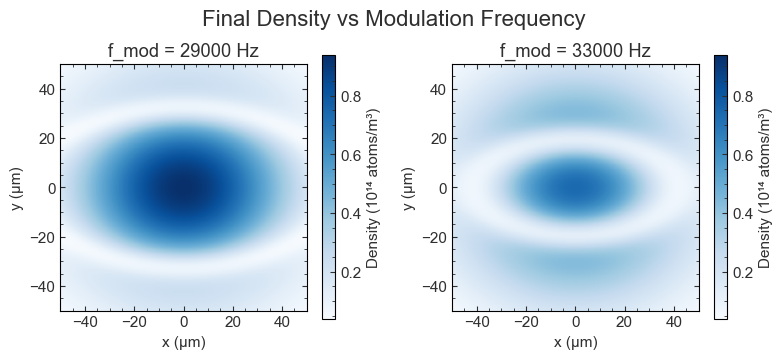

In [231]:
# define trap parameters

power=0.5
waisty_vertical=3.9e-6
wavelen=1.070e-6
waist_hor = 140*1e-6

U = power2freq(power=power, 
               waist = waist_hor,
               waisty=waisty_vertical)
trap = DipoleTrap(waist=waist_hor,
                  waisty=waisty_vertical,
                  wavelen=wavelen,
                  U=U)
# Example: Define beam and meshgrid
beam_params = {
    'k_vec': [0, 1, 0],       # Arbitrary propagation direction
    'w0x': waist_hor,              # 1 mm waist x
    'w0y': waisty_vertical,            # 0.5 mm waist y
    'lambda': 1070e-9,         # 633 nm wavelength
    'waist_pos': [0, 0, 0],   # Beam waist at origin
    'E0': 1.0                 # Field amplitude
}

# Initialize simulator
sim = OpticalTrapSimulator(grid_size=200, physical_size=100e-6)

# Compute the electric field
E = gaussian_beam_field(sim.X, sim.Y, np.zeros_like(sim.X), beam_params)

sheet_trap_freqs = calculate_trap_frequency(U*np.abs(E)**2,waisty_vertical)

results_list = []
mod_frequencies = [29e3,33e3]

for mod_freq in mod_frequencies:
    print(f"  Simulating f_mod = {mod_freq} Hz...")
    
    # Run simulation
    results = sim.simulate_loss(
        trap_frequencies=sheet_trap_freqs,
        mod_freq=mod_freq,
        cloud_size=45e-6,
        cloud_size_y=40e-6,
        mod_depth=0.3,
        linewidth=2700,
        loss_time=20
    )
    results_list.append(results)

# Plot all results in one figure
sim.plot_results_mod_freq_scan(results_list, mod_frequencies)

## Generating sequence of final densities

For further processing to a gif/movie. 

In [232]:
mod_frequencies = np.asarray([10.     , 12.10526, 14.21053, 16.31579, 18.42105, 20.52632,
       22.63158, 24.73684, 26.84211, 28.94737, 31.05263, 33.15789,
       35.26316, 37.36842, 39.47368, 41.57895, 43.68421, 45.78947,
       47.89474, 50.     ])*1e3
       
# Run scan and save data
data = sim.save_mod_freq_scan(
        mod_freq_list=mod_frequencies,
        filename_prefix='li6_trap_scan',
        save_format='npz',  # Use 'npz', 'npy', or 'h5'
        # Simulation parameters
        trap_frequencies=sheet_trap_freqs,
        cloud_size=45e-6,
        cloud_size_y=40e-6,
        mod_depth=0.3,
        linewidth=2700,
        loss_time=20
    )

print(f"\nScan saved! Data shape: {data['final_densities'].shape}")

Running modulation frequency scan for 20 frequencies...
  Processing f_mod = 10000 Hz (1/20)
  Processing f_mod = 12105 Hz (2/20)
  Processing f_mod = 14211 Hz (3/20)
  Processing f_mod = 16316 Hz (4/20)
  Processing f_mod = 18421 Hz (5/20)
  Processing f_mod = 20526 Hz (6/20)
  Processing f_mod = 22632 Hz (7/20)
  Processing f_mod = 24737 Hz (8/20)
  Processing f_mod = 26842 Hz (9/20)
  Processing f_mod = 28947 Hz (10/20)
  Processing f_mod = 31053 Hz (11/20)
  Processing f_mod = 33158 Hz (12/20)
  Processing f_mod = 35263 Hz (13/20)
  Processing f_mod = 37368 Hz (14/20)
  Processing f_mod = 39474 Hz (15/20)
  Processing f_mod = 41579 Hz (16/20)
  Processing f_mod = 43684 Hz (17/20)
  Processing f_mod = 45789 Hz (18/20)
  Processing f_mod = 47895 Hz (19/20)
  Processing f_mod = 50000 Hz (20/20)
Data saved to li6_trap_scan.npz
Scan completed!

Scan saved! Data shape: (20, 200, 200)


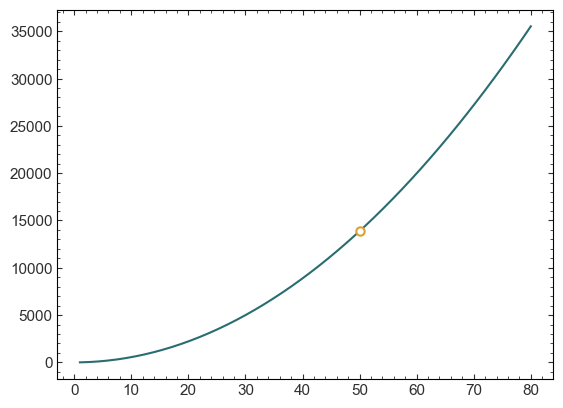

In [220]:
lattice_spacing = 1.064/np.sqrt(2)
system_size = 50 # radius
system_size=np.linspace(1,80)
number_of_sites=np.pi*(system_size/lattice_spacing)**2
plt.plot(system_size, number_of_sites,'-')
plt.plot(50,np.pi*(50/lattice_spacing)**2,ls='',marker='o')
